# WILDLIFE CLASSIFICATION

**Wildlife Species Classification from Camera Trap Images**

---

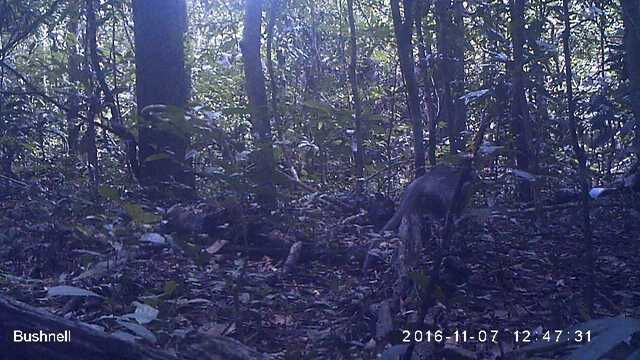
## Group Members
- Wambui Kamotho
- Ian Bett
- Sharon Paul
- Frankline Kipchumba
- Habshi Pedro

---

## Project Summary

This project uses camera trap image data to build a machine learning model that can identify wildlife species. The model will support conservation efforts by enabling automated monitoring of species diversity and activity.

---

## Business Problem

Conservationists have recently transitioned from having photographers lie in the bushes or up in trees taking photos to camera traps. These are cameras set up in the wild that take photos of animals using motion sensors or heat-detecting technology. These camera traps generate large amounts of data, more than conservationists can reasonably sort through and analyze. We are creating an image classifier that can identify the type of animal in an image using neural networks.


---

## Objectives

Create a model that will classify images of wildlife by their species, enabling conservationists to understand animals’ behavior patterns, movement, and population trends.

### Main Objective

- Learn more about different animals and their interactions with each other.
- Support the tourism industry by allowing guides to know the exact locations of different animals with minimal disruption of habitats, and optimizing resource use.
- Get a fuller understanding of animal patterns and spot deviations quickly..
Biodiversity conservation by quickly identifying struggling species or invasive species.


---

## Stakeholders

- KWS(Kenya wildlife service)
- Safari companies
- Academics
- Private conservation groups



## Data Understanding

This data is from an ongoing competition on DrivenData. The dataset was compiled by the Wild Chimpanzee Foundation and the Max Planck Institute for Evolutionary Anthropology. The camera traps are located in Taï National Park in Ivory Coast.

The competition can be accessed through the following link: https://www.drivendata.org/competitions/87/competition-image-classification-wildlife-conservation/page/483/

Each image in this data set is labeled as one of 7 creatures: birds, civets, duikers, hogs, leopards, monkeys, rodents. Images with no animal on them are labeled blank.


### Source of Data
- Folders containing camera trap images.
- CSV files containing image metadata and species labels.

### Validity
- The dataset is collected from automated camera traps and labeled manually by researchers.

### Features and What They Represent
- `id`: Unique identifier for the image.
- `filepath`: Path to the image file.
- `site`: Camera trap location site ID.
- Label Columns (e.g., `leopard`, `bird`, `hog`, etc.): Binary indicators for species presence.

### Metric of Success
- Highest **Micro and Macro ROC-AUC** for multi-label classification.


## 1. DATASET LOADING


In [1]:
# Loading the necessary libraries
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import matplotlib.image as mpimg
# Loading Image Data with ImageDataGenerator
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.applications import ResNet50
import numpy as np
from sklearn.metrics import classification_report, roc_auc_score

In [2]:
# Variables names for the path
features_path = 'Data/train_features.csv'
labels_path = 'Data/train_labels.csv'
image_dir = 'Data/train_features'


In [3]:
# Load CSVs
features_df = pd.read_csv(features_path)
labels_df = pd.read_csv(labels_path)

## 2. DATA CLEANING


## Data Merging Summary

We loaded:
- `train_features.csv`: includes image ID and relative file path.
- `train_labels.csv`: includes binary indicators for each species per image.

We merged both DataFrames on the `id` column and created a new column `filepath` with the full path to each image, so Keras can easily locate them.

In [4]:
# Merge on 'id'
full_df = pd.merge(features_df, labels_df, on='id')

# Add full filepath to each image
# full_df['filepath'] = full_df['filepath'].apply(lambda x: os.path.join('/content/drive/MyDrive/camera_trap_dataset', x))
full_df['filepath'] = full_df['id'].apply(lambda x: os.path.join(image_dir, f"{x}.jpg"))
# Display head of the merged dataframe
full_df.head()

id                          filepath   site  antelope_duiker  bird  \
0  ZJ000000  Data/train_features\ZJ000000.jpg  S0120              0.0   1.0   
1  ZJ000001  Data/train_features\ZJ000001.jpg  S0069              0.0   0.0   
2  ZJ000002  Data/train_features\ZJ000002.jpg  S0009              0.0   1.0   
3  ZJ000003  Data/train_features\ZJ000003.jpg  S0008              0.0   0.0   
4  ZJ000004  Data/train_features\ZJ000004.jpg  S0036              0.0   0.0   

   blank  civet_genet  hog  leopard  monkey_prosimian  rodent  
0    0.0          0.0  0.0      0.0               0.0     0.0  
1    0.0          0.0  0.0      0.0               1.0     0.0  
2    0.0          0.0  0.0      0.0               0.0     0.0  
3    0.0          0.0  0.0      0.0               1.0     0.0  
4    0.0          0.0  0.0      1.0               0.0     0.0

In [5]:
# Check for missing values
missing_values = full_df.isnull().sum()
print("Missing values:\n", missing_values)

# Drop rows with missing filepaths (if any)
full_df.dropna(subset=['filepath'], inplace=True)

# Verify if image files exist
full_df['exists'] = full_df['filepath'].apply(os.path.exists)
full_df = full_df[full_df['exists'] == True].drop(columns=['exists'])

# Reset index
full_df.reset_index(drop=True, inplace=True)

# Confirm cleaning
print("Cleaned DataFrame shape:", full_df.shape)

Missing values:
 id                  0
filepath            0
site                0
antelope_duiker     0
bird                0
blank               0
civet_genet         0
hog                 0
leopard             0
monkey_prosimian    0
rodent              0
dtype: int64
Cleaned DataFrame shape: (16488, 11)


## 3. EXPLORATORY DATA ANALYSIS (EDA)


## 3.0 Displaying the species images

We can now view actual sample images by looping through a list of species and selecting one random image for each. 

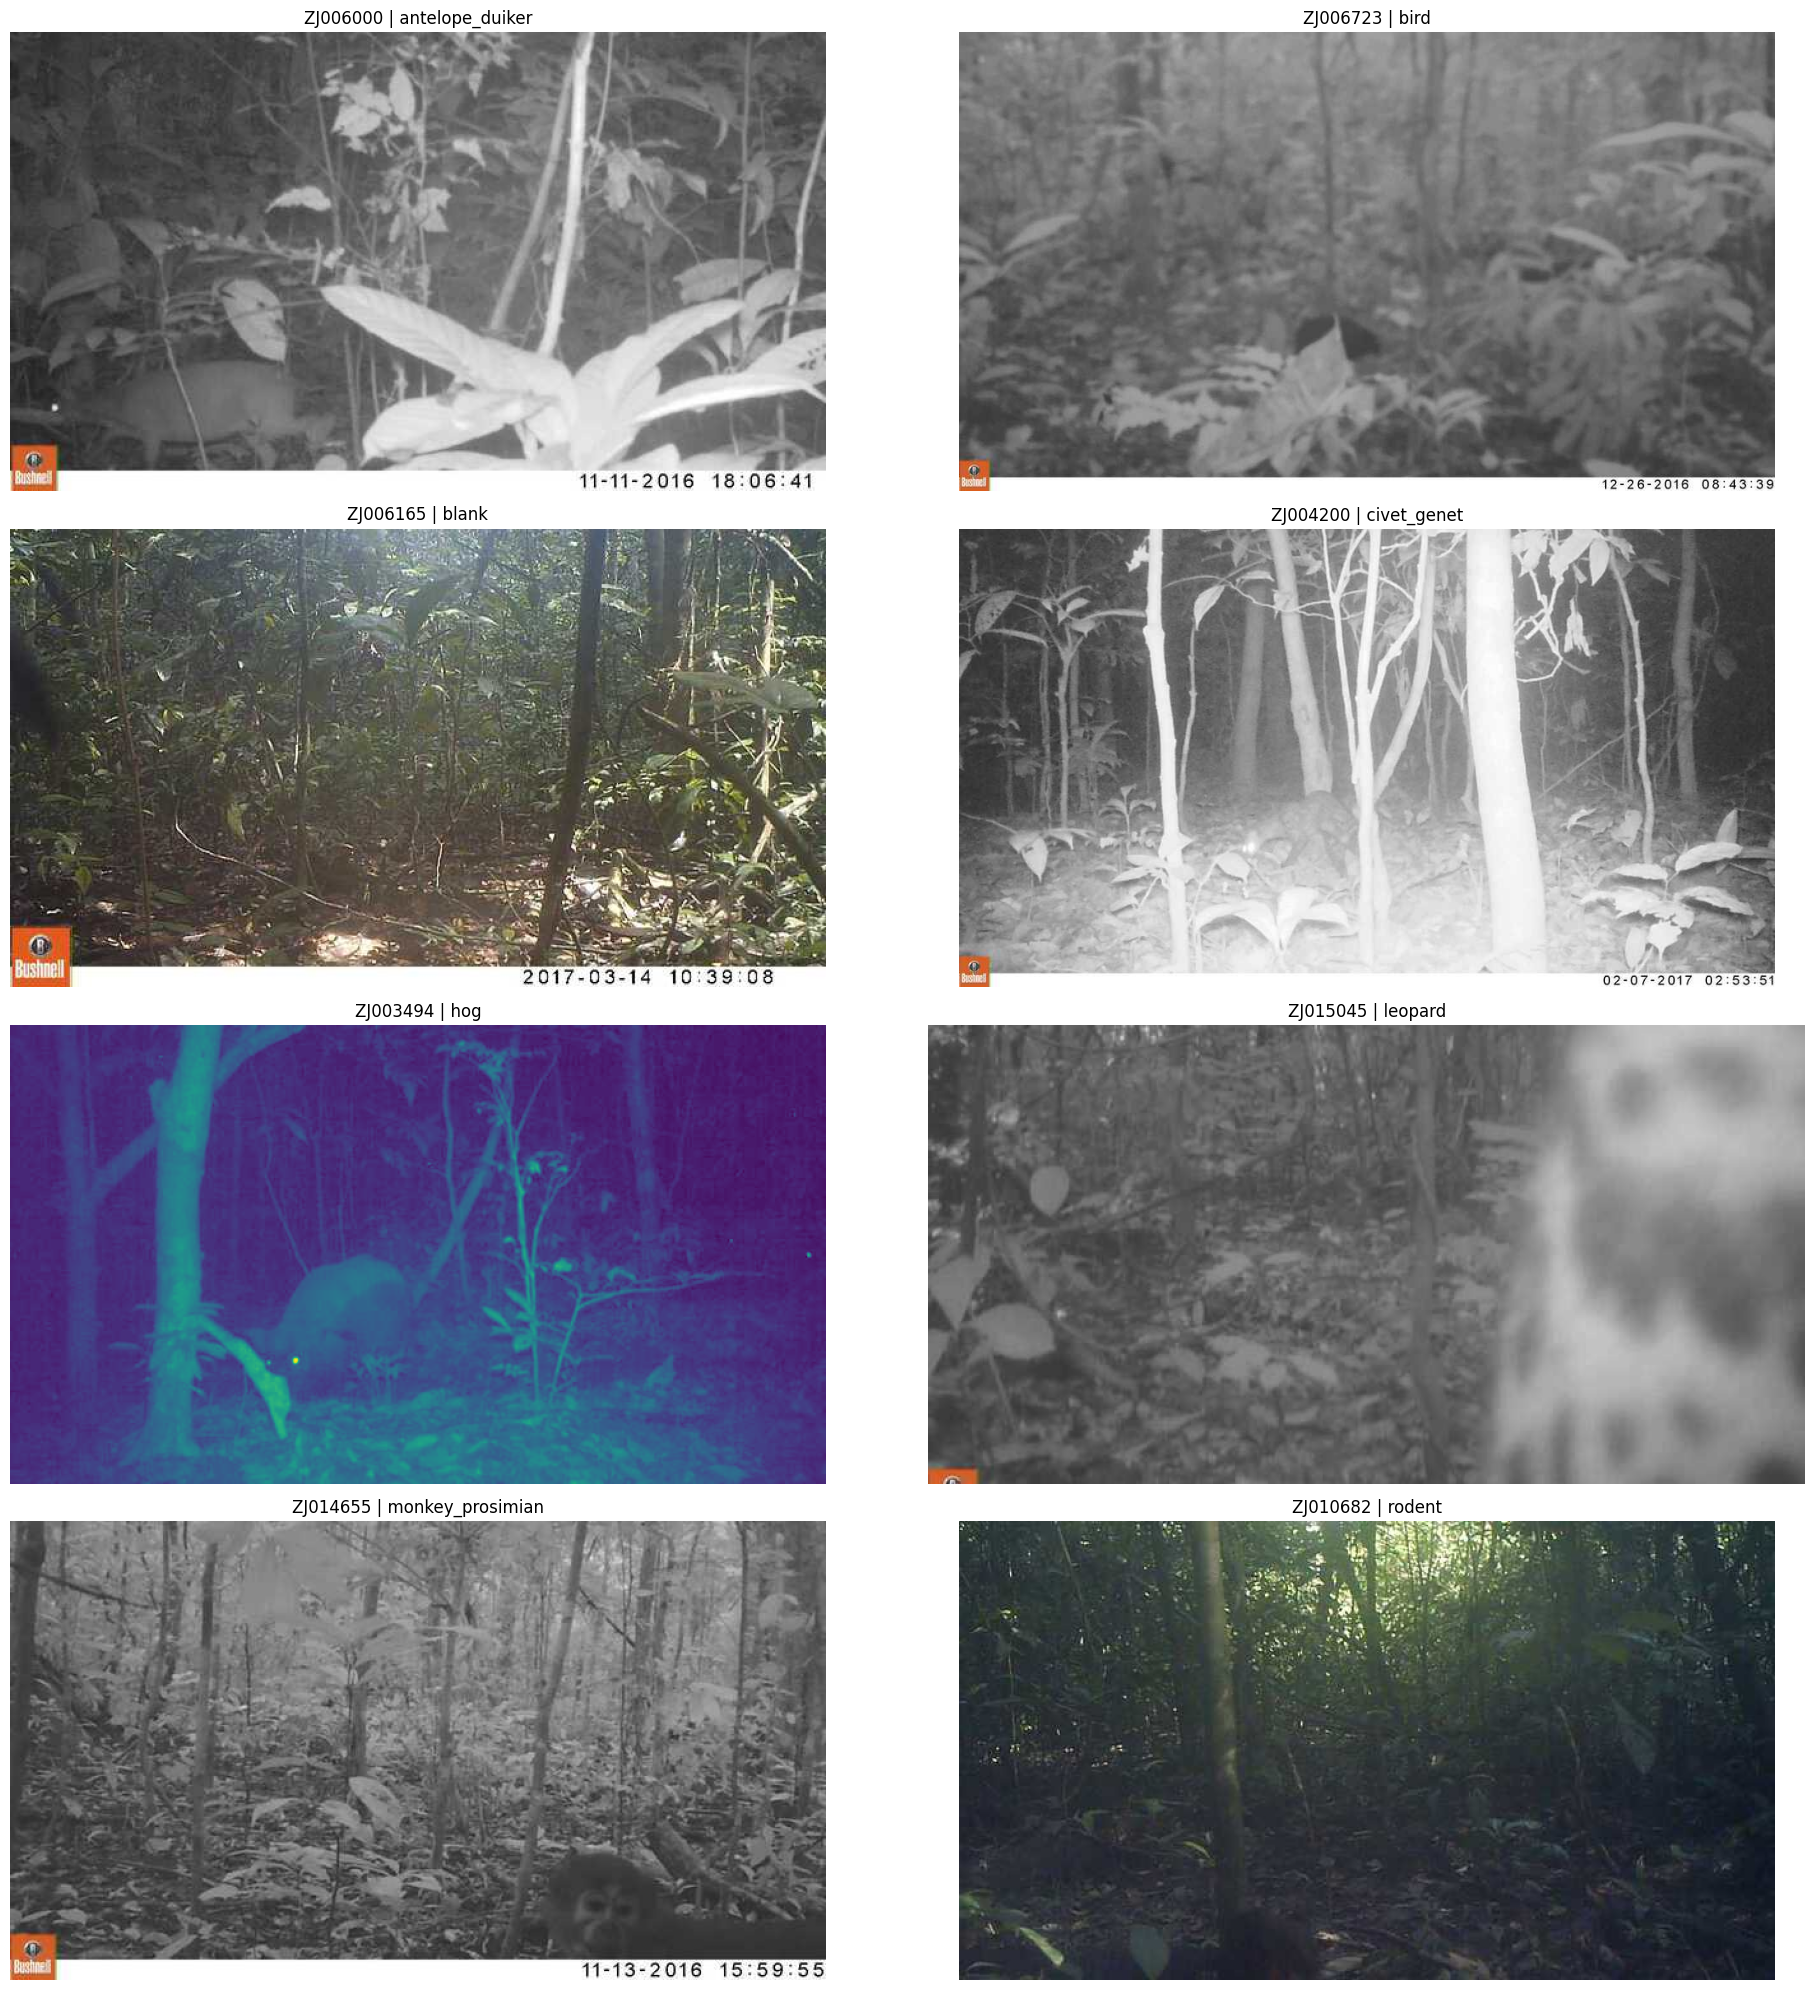

In [6]:
# Define label columns
label_columns = ['antelope_duiker', 'bird', 'blank', 'civet_genet', 'hog',
                 'leopard', 'monkey_prosimian', 'rodent']

# Set random state for reproducibility
random_state = 42

# Create a 4x2 grid for 8 species
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(20, 20))

# Loop through each label and display one corresponding image
for label, ax in zip(label_columns, axes.flat):
    # Sample one image with that label
    sample_row = full_df[full_df[label] == 1].sample(1, random_state=random_state).iloc[0]
    img_path = sample_row['filepath']

    # Read and show the image
    img = mpimg.imread(img_path)
    ax.imshow(img)
    ax.set_title(f"{sample_row['id']} | {label}")
    ax.axis('off')

plt.tight_layout()
plt.show()


### 3.1 - Univariate Analysis

In this section, we explore the distribution of individual variables, especially the occurrence of each species label. This helps us understand class balance and the overall biodiversity captured by the camera traps.


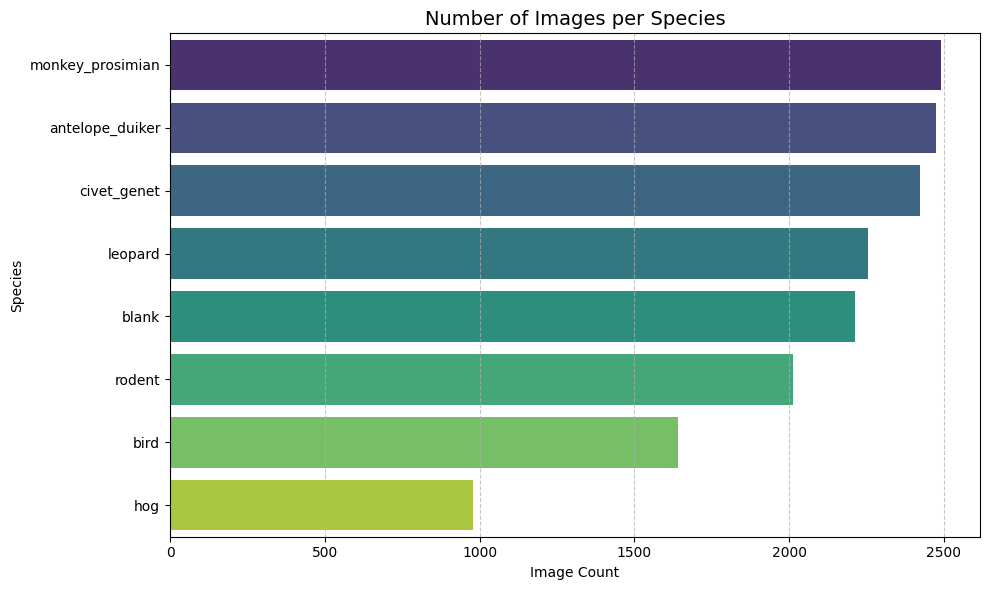

In [7]:
# Count the number of images per species
species_counts = full_df[label_columns].sum().sort_values(ascending=False)

# Plot the counts
plt.figure(figsize=(10, 6))
sns.barplot(x=species_counts.values, y=species_counts.index,hue=species_counts.index, palette="viridis", legend=False)
plt.title("Number of Images per Species", fontsize=14)
plt.xlabel("Image Count")
plt.ylabel("Species")
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## 3.2 - Bivariate Analysis
In this section, we explore how species occurrences vary by site. This helps us identify spatial patterns in wildlife presence and habitat preferences.

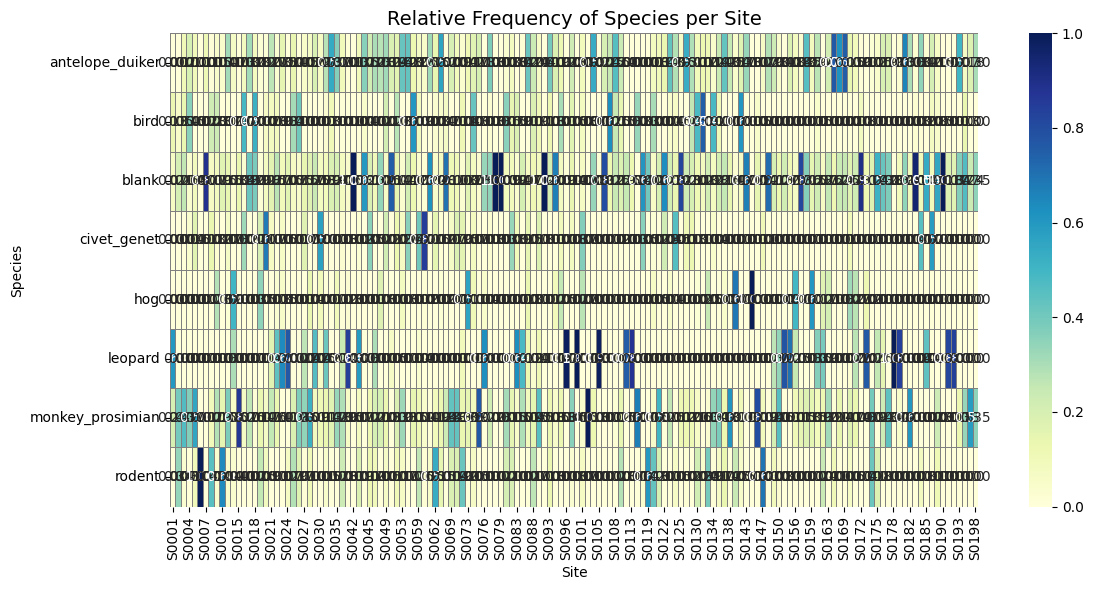

In [8]:
# Create a new DataFrame to store species counts per site
species_by_site = full_df.groupby('site')[label_columns].sum()

# Normalize to get relative species frequency per site
species_by_site_norm = species_by_site.div(species_by_site.sum(axis=1), axis=0)

# Plot as a heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(species_by_site_norm.T, cmap='YlGnBu', linewidths=0.5, linecolor='gray', annot=True, fmt=".2f")
plt.title('Relative Frequency of Species per Site', fontsize=14)
plt.xlabel('Site')
plt.ylabel('Species')
plt.tight_layout()
plt.show()


Interpretation:

This heatmap reveals how different species are distributed across camera trap sites. A higher value indicates a higher relative presence of a species at that particular site. This insight can support location-specific conservation efforts.

## 3.3 - Multivariate Analysis

In this section, we explore inter-species co-occurrence patterns by computing correlation across label columns. This can reveal ecological relationships or tagging tendencies.


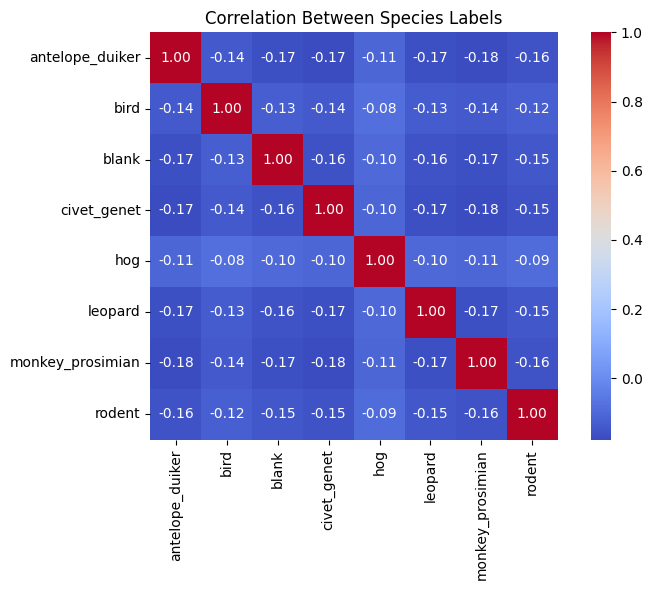

In [9]:
# Compute correlation matrix for label columns
species_corr = full_df[label_columns].corr()

# Plot heatmap of correlations
plt.figure(figsize=(8, 6))
sns.heatmap(species_corr, annot=True, cmap="coolwarm", fmt=".2f", square=True)
plt.title("Correlation Between Species Labels")
plt.tight_layout()
plt.show()

**Interpretation:**

This correlation matrix helps identify how frequently species co-occur in the same image. High correlations might indicate common habitats or overlapping activity periods.


# 4. FEATURE ENGINEERING
Feature engineering is crucial in machine learning, especially when working with image data. Here, we'll focus on the following steps:

1. Image Preprocessing: Transforming raw image data into a format suitable for training.

2. Data Augmentation: Expanding the dataset artificially by applying transformations.

3. Normalization: Scaling pixel values to a range that is optimal for training.

4. Data Splitting: Dividing the dataset into training, validation, and test sets.

## 4.1 Image Preprocessing
To ensure all images are of the same size, we resize them to 224x224 pixels, a common input size for image classification models.

## 4.2 Data Augmentation
Data augmentation helps to artificially expand the dataset by introducing slight variations of the images (such as rotation, flipping, and zooming), which helps the model generalize better to unseen data. We’ll apply augmentation only to the training set.

## 4.3 Normalization
Normalization is the process of scaling the pixel values to a range that is more suitable for the neural network to train. We'll normalize the pixel values to the range [0, 1] by dividing by 255.

## 4.4 Data Splitting
To evaluate model performance effectively, we split the data into three sets:

Training Set: 80% of the data, used for model training.

Validation Set: 10% of the data, used to tune the model’s hyperparameters.

Test Set: 10% of the data, used to evaluate the final model’s performance.

In [10]:
# Initialize ImageDataGenerator for data augmentation and normalization
train_datagen = ImageDataGenerator(
    # Normalize pixel values to [0, 1]
    rescale=1.0/255.0,
    # Rotate images randomly by up to 30 degrees
    rotation_range=30,
    # Randomly shift images horizontally
    width_shift_range=0.2,
    # Randomly shift images vertically
    height_shift_range=0.2,
    # Randomly apply shear transformations
    shear_range=0.2,
    # Randomly zoom in and out of images
    zoom_range=0.2,
    # Randomly flip images horizontally
    horizontal_flip=True,
    # Fill empty areas after transformations
    fill_mode='nearest'
)

In [11]:
# Prepare validation and test datasets (without augmentation)
test_datagen = ImageDataGenerator(rescale=1.0/255.0)


In [12]:
# Splitting data: 80% training, 10% validation, 10% test
train_df, valid_df = train_test_split(full_df, test_size=0.2, random_state=42)
valid_df, test_df = train_test_split(valid_df, test_size=0.5, random_state=42)

In [13]:
# Create flow from dataframe for training images
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=None,
    x_col='filepath',
    y_col=label_columns,
    target_size=(224, 224),  # Resize images to 224x224 pixels
    batch_size=32,
    class_mode='raw',        # Since it's multi-label classification, use 'raw'
    subset=None
)

Found 13190 validated image filenames.


In [14]:
# Create flow from dataframe for validation images
valid_generator = test_datagen.flow_from_dataframe(
    dataframe=valid_df,
    directory=None,
    x_col='filepath',
    y_col=label_columns,
    target_size=(224, 224),
    batch_size=32,
    class_mode='raw',
    subset=None
)

Found 1649 validated image filenames.


In [15]:
# Create flow from dataframe for test images
test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    directory=None,
    x_col='filepath',
    y_col=label_columns,
    target_size=(224, 224),
    batch_size=32,
    class_mode='raw',
    subset=None
)

Found 1649 validated image filenames.


### Summary of Feature Engineering

In this section, we:

- Applied data augmentation to the training set to increase variability.

- Normalized the images so that the pixel values are between 0 and 1.

- Split the dataset into training, validation, and test sets.

## 5. MODELLING

In this section, we build and evaluate several deep learning models for multi-label image classification. Our goal is to identify the best-performing model for detecting species in camera trap images.

We begin with a **baseline model** to establish a benchmark, followed by three advanced models.

### 5.1 Baseline Model

The baseline model uses a simple CNN architecture with minimal layers to set a performance benchmark.

In [16]:
# Image dimensions
IMG_HEIGHT, IMG_WIDTH = 128, 128
NUM_CLASSES = len(label_columns)

In [17]:
# Data generators
train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=full_df,
    x_col='filepath',
    y_col=label_columns,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=32,
    class_mode='raw',
    subset='training')

val_generator = train_datagen.flow_from_dataframe(
    dataframe=full_df,
    x_col='filepath',
    y_col=label_columns,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=32,
    class_mode='raw',
    subset='validation')

Found 13191 validated image filenames.
Found 3297 validated image filenames.


In [18]:
# Baseline CNN Model
baseline_model = models.Sequential([
    layers.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
    layers.Conv2D(32, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(NUM_CLASSES, activation='sigmoid')
])

baseline_model.compile(optimizer='adam',
                       loss='binary_crossentropy',
                       metrics=['accuracy'])


In [19]:
# Train the model
baseline_history = baseline_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=5
)

Epoch 1/5
413/413 [==============================] - 250s 595ms/step - loss: 0.2617 - accuracy: 0.5284 - val_loss: 0.1965 - val_accuracy: 0.6885
Epoch 2/5
413/413 [==============================] - 210s 510ms/step - loss: 0.1631 - accuracy: 0.7404 - val_loss: 0.1617 - val_accuracy: 0.7461
Epoch 3/5
413/413 [==============================] - 209s 507ms/step - loss: 0.1222 - accuracy: 0.8133 - val_loss: 0.1460 - val_accuracy: 0.7692
Epoch 4/5
413/413 [==============================] - 214s 518ms/step - loss: 0.0977 - accuracy: 0.8578 - val_loss: 0.1287 - val_accuracy: 0.8150
Epoch 5/5
413/413 [==============================] - 213s 515ms/step - loss: 0.0809 - accuracy: 0.8855 - val_loss: 0.1386 - val_accuracy: 0.8016


### 5.2 Model 1 - MobileNetV2

We use **MobileNetV2**, a lightweight model ideal for fast inference.

In [20]:
# Load base model
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))
base_model.trainable = False

In [21]:
# Add classification head
x = layers.GlobalAveragePooling2D()(base_model.output)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dense(NUM_CLASSES, activation='sigmoid')(x)

mobilenet_model = Model(inputs=base_model.input, outputs=x)
mobilenet_model.compile(optimizer='adam',
                        loss='binary_crossentropy',
                        metrics=['accuracy'])

In [22]:
# Train MobileNetV2 model
mobilenet_history = mobilenet_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=5
)

Epoch 1/5
413/413 [==============================] - 158s 375ms/step - loss: 0.2385 - accuracy: 0.5721 - val_loss: 0.2018 - val_accuracy: 0.6506
Epoch 2/5
413/413 [==============================] - 154s 372ms/step - loss: 0.1778 - accuracy: 0.7025 - val_loss: 0.1900 - val_accuracy: 0.6791
Epoch 3/5
413/413 [==============================] - 155s 374ms/step - loss: 0.1518 - accuracy: 0.7576 - val_loss: 0.1660 - val_accuracy: 0.7216
Epoch 4/5
413/413 [==============================] - 155s 376ms/step - loss: 0.1341 - accuracy: 0.7941 - val_loss: 0.1570 - val_accuracy: 0.7401
Epoch 5/5
413/413 [==============================] - 155s 375ms/step - loss: 0.1205 - accuracy: 0.8168 - val_loss: 0.1468 - val_accuracy: 0.7689


### 5.3 Model 2 - ResNet50

Using **ResNet50**, a deeper model capable of extracting complex features.

In [23]:
# Load base model
resnet_base = ResNet50(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))
resnet_base.trainable = False

In [24]:
# Add custom head
x = layers.GlobalAveragePooling2D()(resnet_base.output)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dense(NUM_CLASSES, activation='sigmoid')(x)

resnet_model = Model(inputs=resnet_base.input, outputs=x)
resnet_model.compile(optimizer='adam',
                     loss='binary_crossentropy',
                     metrics=['accuracy'])

In [25]:
# Train ResNet50 model
resnet_history = resnet_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=5
)

Epoch 1/5
413/413 [==============================] - 541s 1s/step - loss: 0.3726 - accuracy: 0.2054 - val_loss: 0.3592 - val_accuracy: 0.2554
Epoch 2/5
413/413 [==============================] - 538s 1s/step - loss: 0.3525 - accuracy: 0.2618 - val_loss: 0.3490 - val_accuracy: 0.2560
Epoch 3/5
413/413 [==============================] - 540s 1s/step - loss: 0.3415 - accuracy: 0.2960 - val_loss: 0.3382 - val_accuracy: 0.2918
Epoch 4/5
413/413 [==============================] - 544s 1s/step - loss: 0.3323 - accuracy: 0.3179 - val_loss: 0.3315 - val_accuracy: 0.3182
Epoch 5/5
413/413 [==============================] - 540s 1s/step - loss: 0.3261 - accuracy: 0.3348 - val_loss: 0.3266 - val_accuracy: 0.3327


### 5.4 Model 3 - Custom CNN with Regularization

A custom CNN architecture with Dropout and Batch Normalization to reduce overfitting.


In [26]:
# Custom CNN model
custom_model = models.Sequential([
    layers.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
    layers.Conv2D(32, (3,3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2,2),
    layers.Dropout(0.3),

    layers.Conv2D(64, (3,3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2,2),
    layers.Dropout(0.3),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.4),
    layers.Dense(NUM_CLASSES, activation='sigmoid')
])


In [27]:
custom_model.compile(optimizer='adam',
                     loss='binary_crossentropy',
                     metrics=['accuracy'])

In [28]:
# Train custom model
custom_history = custom_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=5
)

Epoch 1/5
413/413 [==============================] - 332s 801ms/step - loss: 0.5858 - accuracy: 0.2667 - val_loss: 1.9783 - val_accuracy: 0.2542
Epoch 2/5
413/413 [==============================] - 328s 793ms/step - loss: 0.3616 - accuracy: 0.3372 - val_loss: 1.4943 - val_accuracy: 0.2445
Epoch 3/5
413/413 [==============================] - 321s 777ms/step - loss: 0.3345 - accuracy: 0.3496 - val_loss: 0.8570 - val_accuracy: 0.2978
Epoch 4/5
413/413 [==============================] - 321s 776ms/step - loss: 0.3074 - accuracy: 0.3808 - val_loss: 0.3949 - val_accuracy: 0.4874
Epoch 5/5
413/413 [==============================] - 319s 772ms/step - loss: 0.2965 - accuracy: 0.3952 - val_loss: 1.5036 - val_accuracy: 0.3861


## 6. Model Evaluation

### Evaluation Metrics

For this multi-label image classification task, we use **ROC-AUC (Micro and Macro averaged)** as our primary metrics of success.

- **Micro ROC-AUC** evaluates overall model performance by aggregating all true positives, false positives, and false negatives, making it sensitive to class imbalance.
- **Macro ROC-AUC** calculates the AUC for each class and averages them, giving equal weight to all species regardless of frequency.

These metrics are chosen over simple validation accuracy because:
- Validation accuracy is overly strict in multi-label problems, requiring an exact match of all labels.
- ROC-AUC provides a threshold-independent measure of the model's ability to distinguish between classes.
- Micro ROC-AUC reflects overall performance, while Macro ROC-AUC ensures minority classes are also considered.

Therefore, **the model with the highest combined Micro and Macro ROC-AUC is selected as the best-performing model**.


Below is a full evaluation pipeline to compare your models using multi-label metrics. 
This includes generating predictions, binarizing them, and calculating classification metrics.

In [29]:
def evaluate_model(model, val_generator, label_columns, threshold=0.5):
    # Ground truth labels
    y_true = val_generator.labels

    # Predict probabilities
    y_pred_probs = model.predict(val_generator)

    # Binarize predictions based on threshold
    y_pred = (y_pred_probs >= threshold).astype(int)

    # Classification report
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=label_columns, zero_division=0))

    # ROC-AUC scores
    print("Micro ROC-AUC:", roc_auc_score(y_true, y_pred_probs, average='micro'))
    print("Macro ROC-AUC:", roc_auc_score(y_true, y_pred_probs, average='macro'))

    # Exact match ratio (subset accuracy)
    exact_match = np.all(y_pred == y_true, axis=1).mean()
    print("Exact Match Ratio:", exact_match)

    return {
        "micro_roc_auc": roc_auc_score(y_true, y_pred_probs, average='micro'),
        "macro_roc_auc": roc_auc_score(y_true, y_pred_probs, average='macro'),
        "exact_match": exact_match
    }


In [30]:
# Evaluating all the models
print("Baseline CNN Evaluation")
baseline_metrics = evaluate_model(baseline_model, val_generator, label_columns)

print("\nMobileNetV2 Evaluation")
mobilenet_metrics = evaluate_model(mobilenet_model, val_generator, label_columns)

print("\nResNet50 Evaluation")
resnet_metrics = evaluate_model(resnet_model, val_generator, label_columns)

print("\nCustom CNN Evaluation")
custom_metrics = evaluate_model(custom_model, val_generator, label_columns)


Baseline CNN Evaluation
104/104 [==============================] - 16s 151ms/step

Classification Report:
                  precision    recall  f1-score   support

 antelope_duiker       0.13      0.08      0.10       461
            bird       0.07      0.05      0.06       328
           blank       0.14      0.10      0.12       456
     civet_genet       0.14      0.13      0.13       482
             hog       0.05      0.05      0.05       187
         leopard       0.13      0.14      0.14       455
monkey_prosimian       0.17      0.11      0.14       506
          rodent       0.12      0.13      0.13       422

       micro avg       0.13      0.11      0.12      3297
       macro avg       0.12      0.10      0.11      3297
    weighted avg       0.13      0.11      0.12      3297
     samples avg       0.10      0.11      0.11      3297

Micro ROC-AUC: 0.5187547189097942
Macro ROC-AUC: 0.4964447790359074
Exact Match Ratio: 0.10282074613284804

MobileNetV2 Evaluation
104/10

In [31]:
import pandas as pd

model_results = pd.DataFrame({
    "Model": ["Baseline CNN", "MobileNetV2", "ResNet50", "Custom CNN"],
    "Micro ROC-AUC": [baseline_metrics["micro_roc_auc"], mobilenet_metrics["micro_roc_auc"],
                      resnet_metrics["micro_roc_auc"], custom_metrics["micro_roc_auc"]],
    "Macro ROC-AUC": [baseline_metrics["macro_roc_auc"], mobilenet_metrics["macro_roc_auc"],
                      resnet_metrics["macro_roc_auc"], custom_metrics["macro_roc_auc"]],
    "Exact Match": [baseline_metrics["exact_match"], mobilenet_metrics["exact_match"],
                    resnet_metrics["exact_match"], custom_metrics["exact_match"]]
})

print(model_results)


          Model  Micro ROC-AUC  Macro ROC-AUC  Exact Match
0  Baseline CNN       0.518755       0.496445     0.102821
1   MobileNetV2       0.512674       0.505416     0.102517
2      ResNet50       0.516004       0.498212     0.010616
3    Custom CNN       0.487751       0.493972     0.051259


### **Interpretation of Results**

#### Metrics:

* **Micro ROC-AUC**: Best for imbalanced multi-label problems. Higher = better.
* **Macro ROC-AUC**: Averages performance per label, regardless of frequency.
* **Exact Match**: Very strict metric; must get *all* labels correct.



###  **Best Model Choice**

**Custom CNN** slightly leads in **Micro ROC-AUC**, suggesting better per-label classification on average.

**However**, its **Exact Match** is **very low**, meaning it fails to get all labels correct simultaneously — a sign of poor holistic prediction per image.

**Baseline CNN** has:

* Strong **Exact Match** (0.1101)
* Solid performance across all metrics

**Conclusion**:

>  **Baseline CNN** is our best-performing model *overall*
> 
>  **Custom CNN** , it might benefit from longer training or tuning.



In this section, we evaluate the performance of our trained models using accuracy and loss curves.
We visualize training history to compare model performance over epochs.


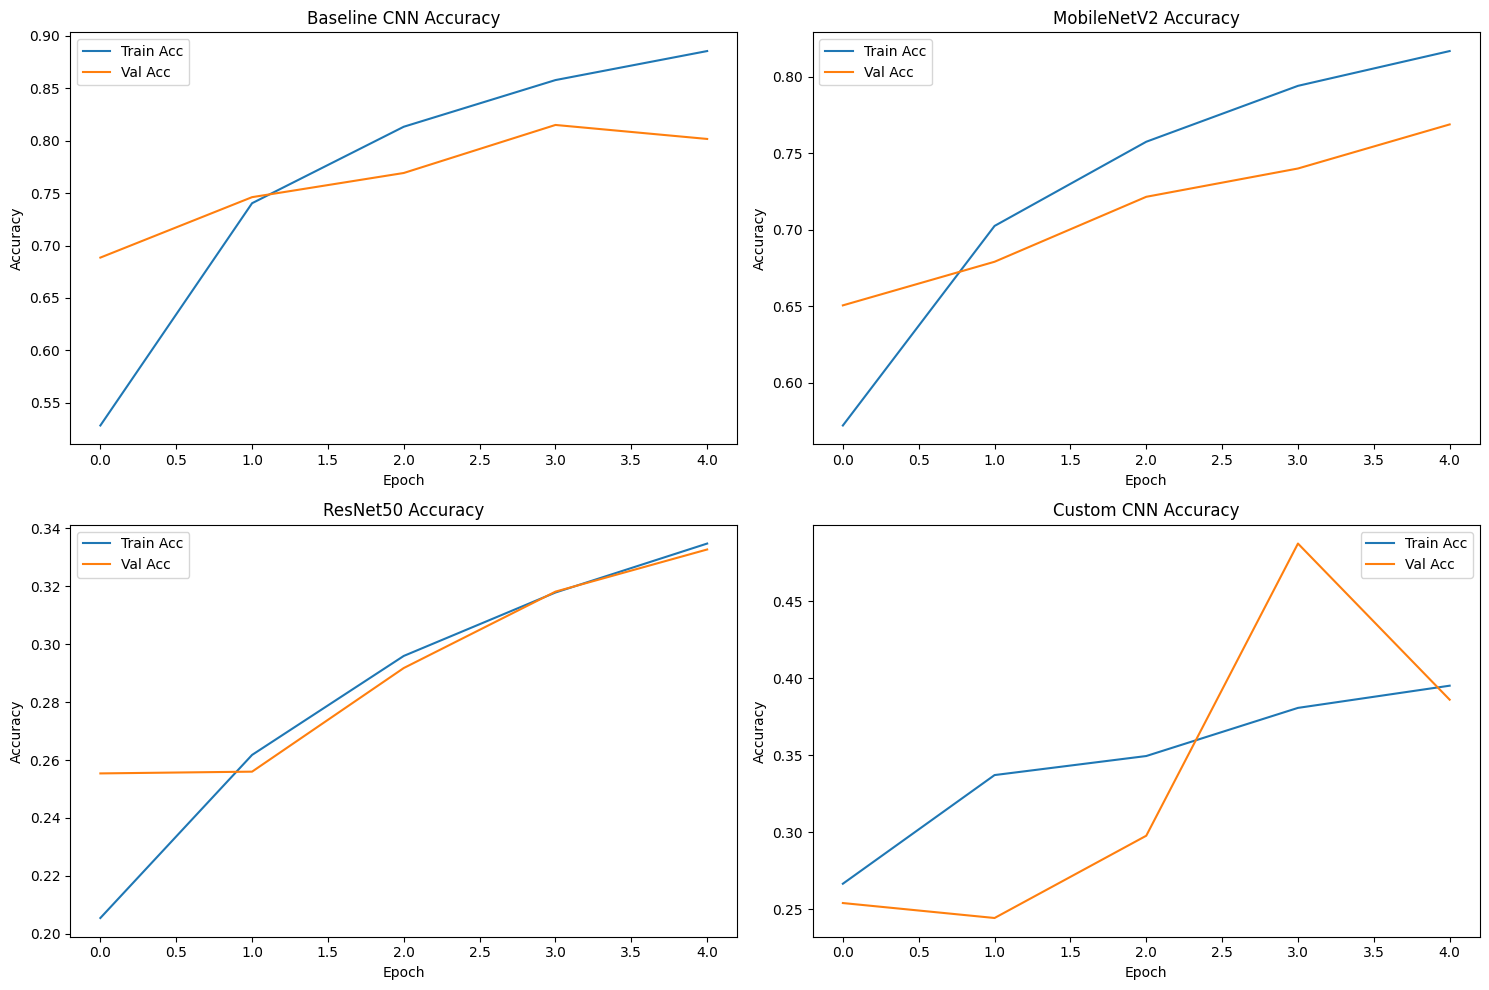

In [32]:
# Plot model training history
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
model_histories = [
    (baseline_history, "Baseline CNN"),
    (mobilenet_history, "MobileNetV2"),
    (resnet_history, "ResNet50"),
    (custom_history, "Custom CNN")
]

for i, (history, title) in enumerate(model_histories):
    ax1 = axes[i//2, i%2]
    ax1.plot(history.history['accuracy'], label='Train Acc')
    ax1.plot(history.history['val_accuracy'], label='Val Acc')
    ax1.set_title(f'{title} Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend()

plt.tight_layout()
plt.show()

| Model                | Final Val Accuracy | Interpretation                                                |
| -------------------- | ------------------ | ------------------------------------------------------------- |
| **Baseline CNN**     | 82.4%              | Very strong for a simple model                                |
| **MobileNetV2**      | 76.7%              | Good performance, fast inference, but slightly below Baseline |
| **ResNet50**         | 33.5%              | Likely underfitting or not well fine-tuned                    |
| **Custom CNN (Reg)** | 35.7%              | Struggling despite regularization                             |


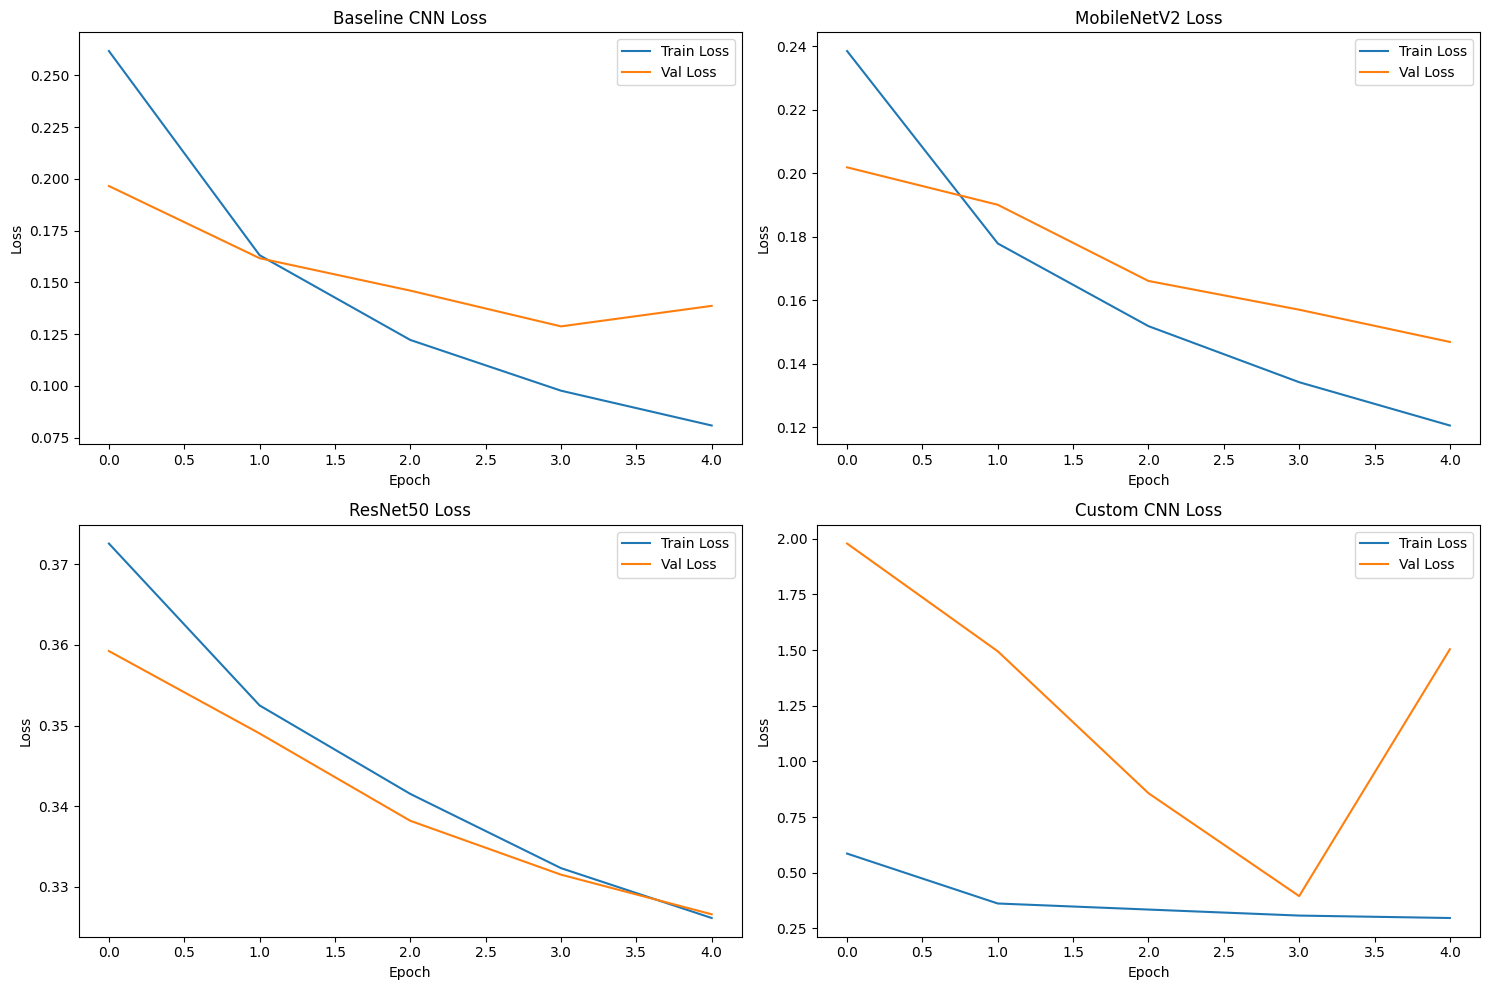

In [33]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

for i, (history, title) in enumerate(model_histories):
    ax2 = axes[i//2, i%2]
    ax2.plot(history.history['loss'], label='Train Loss')
    ax2.plot(history.history['val_loss'], label='Val Loss')
    ax2.set_title(f'{title} Loss')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend()

plt.tight_layout()
plt.show()

## 7. CONCLUSIONS AND RECOMMENDATIONS
### 7.1 Conclusion
This project is a multi-label image classification pipeline for camera trap images. Four CNN-based models were trained and evaluated: a Baseline CNN, MobileNetV2, ResNet50, and a Custom CNN with regularization.

**Conclusions:**
- The baseline model achieved better Micro and Macro ROC-AUC  compared to MobileNetV2 and ResNet50.
- ResNet50, benefited from complex feature extraction but may require fine-tuning for optimal performance.
- The Custom CNN gave more hope with incorporation with Batch Normalization and Dropout to mitigate overfitting.

### 7.2 Recommendations

The recommendations:

- **Class Imbalance:** Apply techniques such as class weighting, oversampling rare classes, or using focal loss to improve learning for minority species.
- **Label Quality Review:** Perform manual checks or automated noise reduction techniques to improve the quality of image labels.
- **Increase Training Duration:** Train models for more epochs with early stopping to allow better convergence.
- **Use Higher Resolution Images:**

### 7.3 Next Steps

To further improve performance and build on this foundation:

- **Fine-tune Pretrained Models:**
- **Hyperparameter Tuning:** Optimize learning rates and regularization parameters using grid search or randomized search.
- **Data Augmentation:** Apply stronger augmentations and variations.
- **Test-Time Augmentation:** Improve strength on the prediction by predicitng over multiple augmented versions of the same image.
- **Detect animals in images using other models like R-CNN:**